In [1]:
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm 
from astropy.cosmology import Planck15 as cosmo

In [2]:
def homemade_calc_mags(mass,age, metals, band='r', cmd_path='bpass_ugriz_sin_imf135_300.npz', bounds_error = False, fill_value = None):
    '''
    age_star: age of stars in this simulation units: yr
    massform: mass of stars in this simulation units: Msol
    metals: metallicity of stars in this simulation units: Zsun
    '''
    
    # load a table of magnitute[age,metalicity]
    lums=np.load(cmd_path)

    # get age and metal in this simulation
    
    #age_star = simstars['age'].in_units('yr')
    #metals = simstars['metals']

    age_star = age
    massform = mass
    # clip age and metal that gets out of table's range
    age_star[age_star < np.min(lums['ages'])] = np.min(lums['ages'])*1.01
    age_star[age_star > np.max(lums['ages'])] = np.max(lums['ages'])*0.99
    metals[metals < np.min(lums['mets'])] = np.min(lums['mets'])*1.01
    metals[metals > np.max(lums['mets'])] = np.max(lums['mets'])*0.99

    # make the table into grid for interpolation
    age_grid = np.log10(lums['ages'])
    met_grid = lums['mets']
    mag_grid = lums[band]

    # 2d interpolate. note that age is converted to "dex" (10^dex)
    # my cmd
    #output_mags = scipy.interpolate.interpn((age_grid,met_grid),mag_grid,(np.log10(age_star),metals))
    # Keri's cmd
    #output_mags = scipy.interpolate.interpn((met_grid,age_grid),mag_grid,(metals,np.log10(age_star)))
    output_mags = scipy.interpolate.interpn(
    (met_grid, age_grid), mag_grid, (metals, np.log10(age_star)),bounds_error = bounds_error, fill_value = fill_value)


    # http://stev.oapd.inaf.it/cgi-bin/cmd
    # http://stev.oapd.inaf.it/cmd_3.6/help.html
    # the magnitudes we get here is "Single-burst stellar populations (SSP), integrated magnitudes (for 1 Msun)"
    # "In CMD, the integrated magnitudes of single-burst stellar population (SSP) are computed for a unit mass of the stellar population
    #  initially born, for the given IMF. They are computed for all filters in the selected photometric system. SP integrated magnitudes
    #  are derived assuming stars populate continuously the entire isochrone,and hence do not include the stochastic variations in the
    #  integrated magnitudes (and colours) that are typical of real SSPs (star clusters)."

    # I guess the following is trying to get the magnitude for the actual mass of our star, instead of 1 Msun
    # https://en.wikipedia.org/wiki/Absolute_magnitude --> Bolometric magnitude. here vals=Mag_star, output_mags=Mag_sun
    # https://en.wikipedia.org/wiki/Mass%E2%80%93luminosity_relation   mass-luminosity relation
    # seems like here it takes alpha=1

    # try:
        # vals = output_mags - 2.5 * np.log10(simstars['massform'].in_units('Msol'))
    # except KeyError as ValueError:
        # vals = output_mags - 2.5 * np.log10(simstars['mass'].in_units('Msol'))
    vals = output_mags - 2.5 * np.log10(massform)
    # make it a SimArray
    # vals=pynbody.array.SimArray(vals)
    # vals.units = None
    return vals



#def homemade_lum_den(simstars,band='r',cmd_path='/home/zj448/Radiative_transfer/SDSS_cmd.npz'):
def homemade_lum_den(mass, age, metals,rho,band='r',cmd_path='bpass_ugriz_sin_imf135_300.npz'):
    mag=homemade_calc_mags(mass = mass, age = age, metals = metals,band=band,cmd_path=cmd_path)
    
    val = (10 ** (-0.4 * mag)) * rho / mass
    # val.units = simstars['rho'].units/simstars['mass'].units
    return val

def homemade_clipping(r,g,b,min_perc):
    maxrgb=np.array([r.max(),g.max(),b.max()]).max()
    if min_perc is None:
        return r/maxrgb,g/maxrgb,b/maxrgb
    else:
        minium=maxrgb*min_perc
        r-=minium
        g-=minium
        b-=minium
        r[r<0]=0
        g[g<0]=0
        b[b<0]=0
        maxrgb=np.array([r.max(),g.max(),b.max()]).max()
        return r/maxrgb,g/maxrgb,b/maxrgb
    

#useage
# rgbim=homemade_render(h[1].s,width='10 kpc',with_dust=True,ret_im=True,plot=True,rgb_scale=[6.5,5.25,3.])
def homemade_normalize(r,g,b):
    maxrgb=np.array([r.max(),g.max(),b.max()]).max()
    minrgb=np.array([r.min(),g.min(),b.min()]).min()
    r=(r-minrgb)/(maxrgb-minrgb)
    g=(g-minrgb)/(maxrgb-minrgb)
    b=(b-minrgb)/(maxrgb-minrgb)
    return r,g,b
    
    
    

In [3]:
from megs.data.simulations import illustrisAPI, scale_to_physical_units

In [4]:
from megs.data.image import image2D,face_on_rotation,horizontal_rotation
def rotate_galaxy(particle_coordinates,
                  particle_masses,
                    rHalf,
                    subhalo_pos,
                    smoothing_length,
                    res = 64,
                  _plotfactor=10):
        """Rotate the galaxy to face-on and horizontal orientation.

        This function is called when the galaxy object is initialized. It is not necessary to call it again. First the galaxy is rotated face-on and then horizontal.
        The rotation is done using the rotation.py module.

        Parameters
        ----------
        _plotfactor : int, optional
            Factor used in the horizontal_rotation method defined in the rotation.py module to scale the image. The default is 10. For more information see the documentation of the horizontal_rotation method.

        Returns
        -------
        numpy.array
            The rotated coordinates of the galaxy.
        """
    
        face_on_rotated_coords, rotation_matrix_face_on = face_on_rotation(
            coordinates=particle_coordinates,
            particle_masses=particle_masses,
            rHalf=rHalf,
            subhalo_pos=center,
            return_rotation_matrix=True,
        )
        # maybe horizontal rotataion is not working properly
        # Create temporary image to get the rotation angle: Maybe there is a better way to do this. Only calculating a hist does not work properly.
        img = image2D(coordinates=face_on_rotated_coords, R_half=rHalf, 
                      weights = particle_masses,smoothing_length=smoothing_length, 
                      plot_factor = _plotfactor,res = res)
        horizontal_rotated_coords, rotation_matrix_horizontal = horizontal_rotation(
            img=img,
            coordinates=face_on_rotated_coords,
            halfmassrad=rHalf,
            plotfactor=_plotfactor,
            return_rotation_matrix=True,
        )
        return horizontal_rotated_coords

In [5]:
api = illustrisAPI(api_key="05add2d69d501eb62014faa4dadb1af0",snapshot=99, particle_type="stars")

fields = ["GFM_Metallicity","GFM_InitialMass","GFM_StellarFormationTime","Masses", 
          "SubfindHsml", "SubfindDensity", "Coordinates"]
halo_id = 5
data = api.get_particle_data(halo_id,fields)
print(data.keys())

# Get the stellar mass and metallicity of each star particle
initmassStar = scale_to_physical_units(data["GFM_InitialMass"], "Masses")# Initial mass in Msun when star particle formed
massStar = scale_to_physical_units(data["Masses"], "Masses") # Mass in Msun
zstar = scale_to_physical_units(data["GFM_Metallicity"], "GFM_Metallicity") # Metallicity in solar units
tform = data["GFM_StellarFormationTime"]
age = scale_to_physical_units(tform, "GFM_StellarFormationTime")
h = data["SubfindHsml"] # smoothing length in kpc
coords= scale_to_physical_units(data["Coordinates"], "Coordinates")
rho = scale_to_physical_units(data["SubfindDensity"], "SubfindDensity")

subhalo = api.get_subhalo(halo_id)
center = np.array([subhalo["pos_x"],subhalo["pos_y"],subhalo["pos_z"]])
center = scale_to_physical_units(center, "Coordinates")
rHalf = scale_to_physical_units(subhalo["halfmassrad_stars"], "Coordinates")

dict_keys(['Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses', 'SubfindDensity', 'SubfindHsml'])


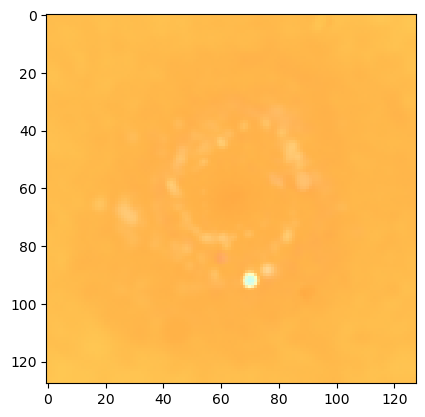

In [6]:
metals = zstar*0.0127
mstar = initmassStar.copy()
rho_ = rho.copy()

rval = homemade_lum_den(mstar, age, metals, rho_, band='i', cmd_path='bpass_ugriz_sin_imf135_300.npz')
gval = homemade_lum_den(mstar, age, metals, rho_, band='r', cmd_path='bpass_ugriz_sin_imf135_300.npz')
bval =  homemade_lum_den(mstar, age, metals, rho_, band='g', cmd_path='bpass_ugriz_sin_imf135_300.npz')


#rval,gval,bval = homemade_normalize(rval,gval,bval)

rotated_coords = rotate_galaxy(particle_coordinates=coords,
                               particle_masses =mstar, rHalf = rHalf, subhalo_pos = center, 
                               smoothing_length = h, res = 64, _plotfactor=10)



plot_factor = 5
imgres = 128


r = image2D(coordinates=rotated_coords, R_half=rHalf, weights = rval, smoothing_length=h, plot_factor = plot_factor,res = imgres)
g = image2D(coordinates=rotated_coords, R_half=rHalf, weights = gval, smoothing_length=h, plot_factor = plot_factor,res = imgres)
b = image2D(coordinates=rotated_coords, R_half=rHalf, weights = bval, smoothing_length=h, plot_factor = plot_factor,res = imgres)

#r,g,b = render()
rgb_img = make_lupton_rgb(r, g, b, stretch=0.1, Q=20)
plt.imshow(rgb_img)